In [12]:
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.layers import Embedding, Flatten
from keras.layers import Conv2D, GlobalAveragePooling2D, MaxPooling2D
import math
import numpy as np

data_gen = ImageDataGenerator(rescale=1.0/255)

In [2]:
imgdir = 'a5_images'
img_size = 64
batch_size = 32

train_generator = data_gen.flow_from_directory(
        imgdir + '/train',
        target_size=(img_size, img_size),
        batch_size=batch_size,
        class_mode='binary',
        classes=['other', 'car'],
        shuffle=True)

Found 1600 images belonging to 2 classes.


In [3]:
Xbatch, Ybatch = train_generator.next()

In [4]:
from matplotlib import pyplot as plt
plt.style.use('bmh')
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

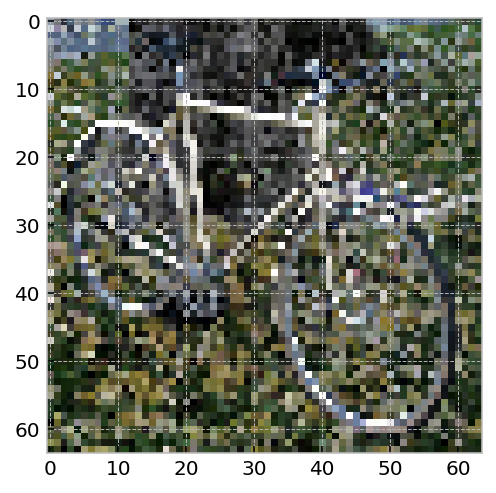

In [5]:
plt.imshow(Xbatch[0]);

In [6]:
Xbatch = Xbatch.reshape(Xbatch.shape[0], img_size, img_size, 3)
#x_test = x_test.reshape(Xbatch.shape[0], img_width, img_height, 1)
#Xbatch = Xbatch / 255
#x_test = x_test / 255

def make_convnet(img_width, img_height, c):
    model = Sequential()
    model.add(Conv2D(32, kernel_size=(5, 5), strides=(1, 1),
                     activation='relu',
                     input_shape=(img_width, img_height, 3)))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
    model.add(Conv2D(64, (5, 5), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    #model.add(Dense(1, activation='elu'))
    model.add(Dense(1, activation='sigmoid'))
    
    model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])
    return model
    
cnn = make_convnet(img_size, img_size, 3)    

Instructions for updating:
Colocations handled automatically by placer.


In [7]:
validation_generator = data_gen.flow_from_directory(
        imgdir + '/validation',
        target_size=(img_size, img_size),
        batch_size=batch_size,
        class_mode='binary',
        classes=['other', 'car'],
        shuffle=True)

Found 576 images belonging to 2 classes.


In [8]:
#cnn = make_convnet()
trainingBatchSize = math.ceil( 1600 / batch_size)
validationBatchSize = 5
history = cnn.fit_generator(train_generator, 
                  validation_data=validation_generator, 
                  steps_per_epoch=trainingBatchSize,
                  validation_steps=validationBatchSize,
                  epochs=10,
                  use_multiprocessing=False)

Instructions for updating:
Use tf.cast instead.
Epoch 1/10
50/50 [==============================] - 19s 375ms/step - loss: 0.7084 - acc: 0.5694 - val_loss: 0.6466 - val_acc: 0.5938
Epoch 2/10
50/50 [==============================] - 14s 284ms/step - loss: 0.5680 - acc: 0.7025 - val_loss: 0.5256 - val_acc: 0.7562
Epoch 3/10
50/50 [==============================] - 15s 297ms/step - loss: 0.4959 - acc: 0.7612 - val_loss: 0.4977 - val_acc: 0.7562
Epoch 4/10
50/50 [==============================] - 14s 290ms/step - loss: 0.4418 - acc: 0.8006 - val_loss: 0.5450 - val_acc: 0.7562
Epoch 5/10
50/50 [==============================] - 15s 294ms/step - loss: 0.3845 - acc: 0.8206 - val_loss: 0.6066 - val_acc: 0.7937
Epoch 6/10
50/50 [==============================] - 14s 284ms/step - loss: 0.3969 - acc: 0.8275 - val_loss: 0.5981 - val_acc: 0.7250
Epoch 7/10
50/50 [==============================] - 15s 299ms/step - loss: 0.3307 - acc: 0.8531 - val_loss: 0.5670 - val_acc: 0.7812
Epoch 8/10
50/50 [===

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


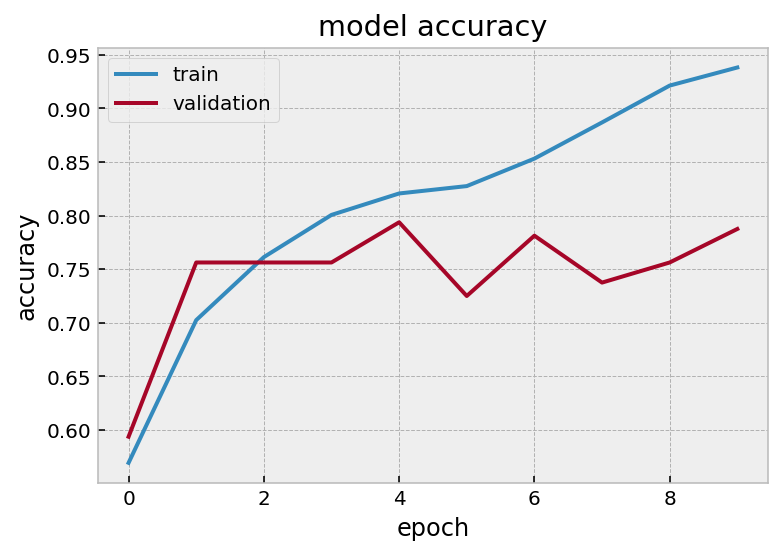

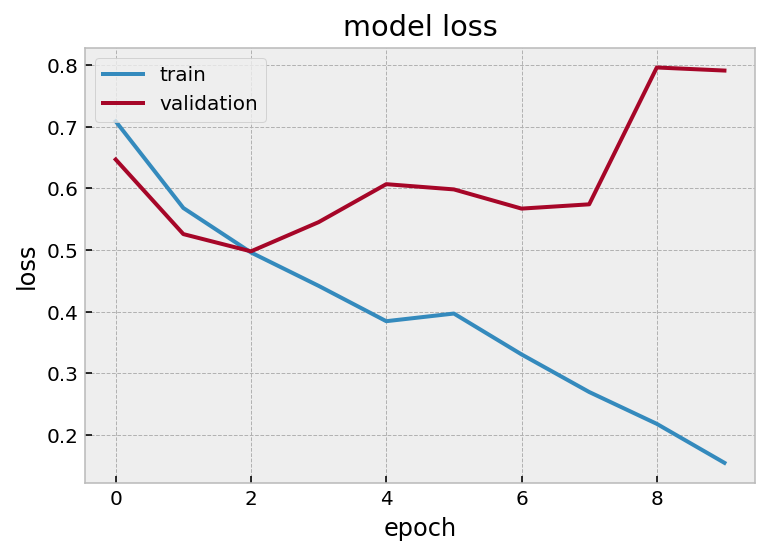

In [9]:
print(history.history.keys())
#  "Accuracy"
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# "Loss"
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

[[('n03594945', 'jeep', 0.92140627),
  ('n04252225', 'snowplow', 0.0243272),
  ('n03445924', 'golfcart', 0.014407205),
  ('n03930630', 'pickup', 0.012664951),
  ('n03478589', 'half_track', 0.005270824)]]

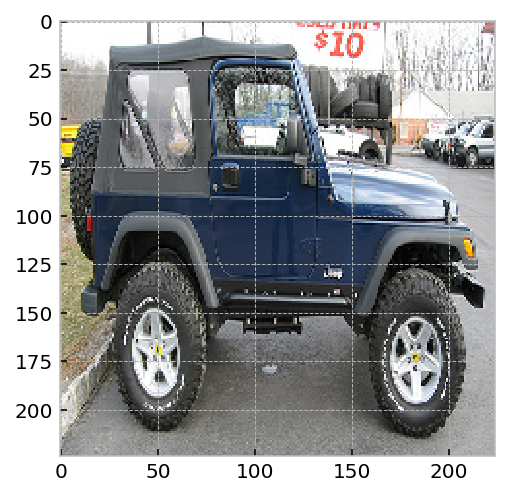

In [10]:
from keras import applications
from keras.applications.imagenet_utils import decode_predictions, preprocess_input
from keras.preprocessing.image import load_img, img_to_array

vggmodel = applications.VGG16(weights='imagenet', include_top=True)
img = load_img('a5_images/validation/car/0000.jpg', target_size=(224,224))
plt.imshow(img);
imgArray = img_to_array(img)
imgVGG = preprocess_input(imgArray)
imgVGG = imgVGG.reshape(1, 224, 224, 3)
decode_predictions(vggmodel.predict(imgVGG))

In [118]:
feature_extractor = applications.VGG16(include_top=False, weights='imagenet',
                                       input_shape=(img_size, img_size, 3))
vgg_data_gen = ImageDataGenerator(preprocessing_function=preprocess_input)

def create_vgg16_features(subdir):
    generator = vgg_data_gen.flow_from_directory(
        imgdir + '/' + subdir,
        target_size=(img_size, img_size),
        batch_size=batch_size,
        shuffle=False)
    if subdir == 'train' : step_size = 1600/batch_size
    else : step_size = 576/batch_size
    cnn_features = feature_extractor.predict_generator(generator, steps=step_size, verbose=1)
    with open('vgg16_' + subdir, 'wb') as f:
      np.save(f, cnn_features)

create_vgg16_features('train')
create_vgg16_features('validation')


Found 1600 images belonging to 2 classes.
50/50 [==============================] - 57s 1s/step
Found 576 images belonging to 2 classes.
18/18 [==============================] - 21s 1s/step


In [133]:
def make_vggnet():
    model = Sequential()
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])
    return model  

def get_labels(n):
    return np.array([0]*(n//2) + [1]*(n//2))    

def train_on_cnnfeatures():
    with open('vgg16_train', 'rb') as f:
        train_data = np.load(f)
    with open('vgg16_validation', 'rb') as f:
        val_data = np.load(f)
    vggmodel = make_vggnet()    
    vggmodel.fit(x=train_data, 
                 y=get_labels(1600), 
                 epochs=10, 
                 validation_data=[val_data, get_labels(576)],
                 steps_per_epoch=32, 
                 validation_steps=32)

In [134]:
train_on_cnnfeatures()

Train on 1600 samples, validate on 576 samples
Epoch 1/10
32/32 [==============================] - 2s 74ms/step - loss: 0.6210 - acc: 0.9436 - val_loss: 1.0047 - val_acc: 0.8958
Epoch 2/10
32/32 [==============================] - 1s 33ms/step - loss: 0.2153 - acc: 0.9865 - val_loss: 0.9870 - val_acc: 0.8924
Epoch 3/10
32/32 [==============================] - 1s 46ms/step - loss: 0.1390 - acc: 0.9912 - val_loss: 1.0744 - val_acc: 0.8906
Epoch 4/10
32/32 [==============================] - 1s 31ms/step - loss: 0.1200 - acc: 0.9925 - val_loss: 1.0268 - val_acc: 0.8941
Epoch 5/10
32/32 [==============================] - 2s 49ms/step - loss: 0.1200 - acc: 0.9925 - val_loss: 1.0238 - val_acc: 0.8924
Epoch 6/10
32/32 [==============================] - 1s 32ms/step - loss: 0.1200 - acc: 0.9925 - val_loss: 1.0222 - val_acc: 0.8941
Epoch 7/10
32/32 [==============================] - 1s 44ms/step - loss: 0.1200 - acc: 0.9925 - val_loss: 1.0223 - val_acc: 0.8941
Epoch 8/10
32/32 [==================